## Calculating the Vibrational Modes of the Formic Acid Dimer using a High-Dimensional Neural Network Potential

This Jupyter Notebook is written for the SPP tutorial in July 2023 by **Moritz R. Schäfer** (moritz.schaefer-f91@rub.de, Lehrstuhl für Theoretische Chemie II, Ruhr-Universität Bochum; Research Center Chemical Sciences and Sustainability, Research Alliance Ruhr).

The most recent version of RuNNer is [hosted on Gitlab](https://gitlab.com/TheochemGoettingen/RuNNer). For access please contact Prof. Dr. Jörg Behler (joerg.behler@rub.de).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Layout, widgets, interact

from ase import Atoms
from ase.calculators.calculator import PropertyNotImplementedError
from ase.vibrations import Vibrations
from ase.optimize import BFGS

from runnerase import Runner, RunnerScaling, RunnerWeights
from runnerase import read_runnerconfig, read
from runnerase import generate_symmetryfunctions

from helpers import view_ngl, plot_energy
#from helpers import plot_energy
from ase.visualize import view

This global variable tells Python where to find the RuNNer executable. In this notebook we will use the outdated RuNNer version 1.1 which can be installed via conda/mamba. For production, you should compile the most recent version of RuNNer on your machine.

In [2]:
RUNNER_COMMAND = 'RuNNer.serial.x > PREFIX.out'

## Background

**RuNNer** is a stand-alone Fortran program for the construction of high-dimensional neural network potentials (HDNNPs), written mainly by Jörg Behler. The central assumption made in constructing a HDNNP is that the total energy of the system $E_{\mathrm{tot}}$ [can be separated into atomic contributions $E_i$](https://www.doi.org/10.1103/PhysRevLett.98.146401). HDNNPs relate the local environment of the atoms to their atomic energies $E_i$, which contribute to the sum of all $N$ atomic energies, resulting in the total energy of the system $E_\mathrm{tot}$.

\begin{align}
    E_\mathrm{tot} = \sum_{i}^{N}E_i\notag
\end{align}

Every atomic energy is described by an atomic neural network (NN), which is element-specific. The entirety of all atomic NNs composes a HDNNP, whose general architecture is shown below for a binary system.

<div>
<img src="figures/2g.png" width="500"/>
</div>

As you can see, the atomic contributions in this model are predicted independently from each other. Therefore, the model can easily describe systems with differering numbers of atoms: adding or removing an atom corresponds to adding or removing a row in the figure shown above. This ability is what puts the "high-dimensional" into the name "HDNNP". 

Each atomic neural networks receives input information about the local atomic environment up to a certain cutoff radius $R_{\mathrm{c}}$. This information is encoded based on the Cartesian coordinates in many-body descriptors, so-called [atom-centered symmetry functions (ACSF or just SF)](https://www.doi.org/10.1063/1.3553717). For each atom, the values of multiple SFs compose a SF vector $G$ which is the input layer of the atomic NNs.

Atomic NNs look like this:

<div>
<img src="figures/ann.png" width="500"/>
</div>

Every value in the SF vector $G$ serves as one piece of input information to the atomic NN. We refer to the circles in the figure as _nodes_ (from graph theory) or _neurons_ (from neural science). The information from the input nodes flows through the atomic NN from left to right: the input layer is followed by a configurable number of hidden layers which consist, in turn, of an arbitrary number of _hidden nodes_. At the end, all information is collected in the output layer, which in our case is interpreted as the atomic energy contribution of the atom under consideration. The input nodes and the hidden nodes in the first layer are connected by weights. Moreover, the hidden and output nodes carry a bias value.

During training, the weights and biases are optimized using backpropagation to represent best the data in the training data set.

# Using RuNNer via the Atomic Simulation Environment (ASE)

In general, training a HDNNP with **RuNNer** can be separated into three different stages - so-called modes - in which different types of calculation are performed.

- **Mode 1:** calculation of the SF values and separation of the dataset into a training and testing set.
- **Mode 2:** training of the model to construct the HDNNP.
- **Mode 3:** prediction of energy and forces (stress and charges can also be predicted).

All these steps are performed consecutively beginning with mode 1.

The [Atomic Simulation Environment](https://wiki.fysik.dtu.dk/ase/index.html) (ASE) is "a set of tools and Python modules for setting up, manipulating, running, visualizing and analyzing atomistic simulations.". It can interact with varius standalone codes through so-called `calculators`. For example, you can run DFT calculations using VASP or FHIaims, or control MD simulations with LAMMPS.

We have [implemented RuNNer in ASE](https://runner-suite.gitlab.io/runnerase/0.3.3/) so you can very easily set up and analyze HDNNPs from Python.

## Data Preparation

The dataset as well as the fit loaded used in this notebook were published [in this paper](https://doi.org/10.1039/D2CP03893E) by Rasheeda *et al*. 

The creation of a meaningful neural network potential lives and dies with high quality training data. Therefore, we will begin by inspecting the full training dataset that was generated with highly accurate, explicitly correlated, frozen-core (fc-)CCSD(T)-F12a in conjunction with an aug-cc-pVTZ basis 95 for carbon and oxygen atoms and a cc-pVTZ basis for hydrogen atoms. 

ASE comes with functions to read in a RuNNer dataset:

In [3]:
dataset = read('data/pretrained_potential/input.data', index=':', format='runner')

Now we can take a look at the distribution of energies in the dataset (we have written a small function in helpers.py for that):

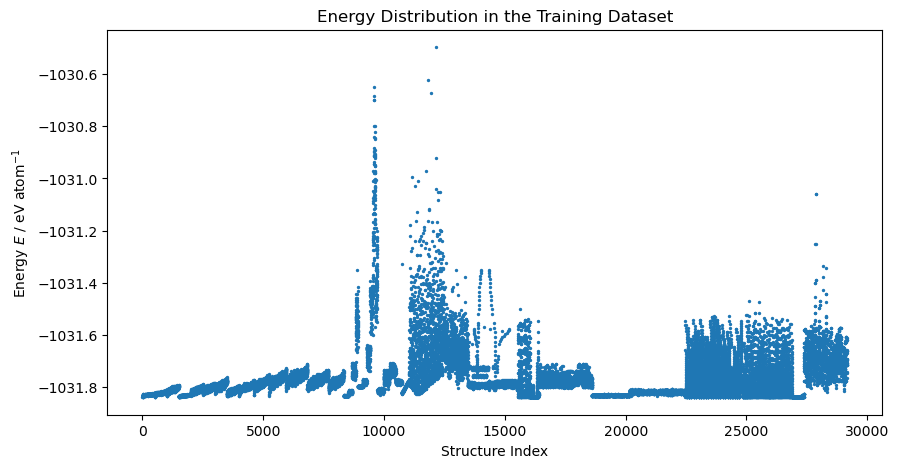

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_energy(dataset)
plt.show()

## Part 1: Training a Toy Potential

External codes can interface with ASE through a `calculator` object. In `runnerase`, we have implemented a calculator called `Runner`. Let us create an object for this:

In [5]:
runnercalc = Runner(command=RUNNER_COMMAND)
runnercalc.set(random_seed=42)

{'random_seed': 42}

The calculator is initialized with a sensible choice of input parameters for RuNNer (`parameters` property) and an empty storage for the training dataset (`dataset`).

### Adding Training Data

As of yet, this job does not have a training dataset. For this tuturial, we will only use andomly added 200 points from the dataset. This drastically speeds up the fitting process, but as you will see, results in a rather poor fit.

In [6]:
subset = dataset[:200]

In [7]:
runnercalc.dataset = subset
len(runnercalc.dataset)

200

### Specification of RuNNer Parameters

While many of the default parameters in `Runner` are suited for a wide range of calculations, you still need to carefully check each of them before starting a fit. Special attention must be given to the atom-centered symmetry functions as they have to be tailored to the system under investigation.

In this short notebook we will not investigate RuNNer's parameters/keywords in detail. If you want to use RuNNer for your own projects, please have a look at the more comprehensive notebook handson.ipynb which lists all keywords and gives advice on how to tune them.

#### Generating Symmetry Functions with runnerase

The parameter `symfunction_short` is a so-called `SymmetryFunctionSet` object. They function similar to a folder: you can either store `SymmetryFunction` objects directly (= a file), or create more `SymmetryFunctionSet`s in them (= another folder).

runnerase comes with a nifty `generate_symmetryfunctions` routines. When it is is called, it returns a `SymmetryFunctionSet` itself. Two `SymmetryFunctionSet`s can easily be combined using the `+` operator. This way, we can add a collection of radial and angular symmetry functions to our job.

In [8]:
# Reset the symmetry function container.
runnercalc.symmetryfunctions.reset()

# Generate radial and angular symmetry functions.
radials = generate_symmetryfunctions(subset, sftype=2, amount=6,
                                     algorithm='turn', cutoff=12.0)
angulars = generate_symmetryfunctions(subset, sftype=3, amount=4,
                                      algorithm='literature', cutoff=12.0)

# Add SFs to the calculator.
runnercalc.symmetryfunctions += radials
runnercalc.symmetryfunctions += angulars

When you now take a look at the parameters, you will find that the symfunction_short keyword is no longer empty:

In [9]:
runnercalc.parameters

{'runner_mode': 1,
 'symfunction_short': [('H', 2, 'H', 7.709882115452476e-19, 0.0, 12.0), ('H', 2, 'H', 0.001430523575087969, 0.0, 12.0), ('H', 2, 'H', 0.003256374422093298, 0.0, 12.0), ('H', 2, 'H', 0.005535335733310726, 0.0, 12.0), ('H', 2, 'H', 0.008344679918161955, 0.0, 12.0), ('H', 2, 'H', 0.011803292426545844, 0.0, 12.0), ('H', 2, 'C', 7.709882115452476e-19, 0.0, 12.0), ('H', 2, 'C', 0.004281342284273828, 0.0, 12.0), ('H', 2, 'C', 0.011622406252932678, 0.0, 12.0), ('H', 2, 'C', 0.024241807265882005, 0.0, 12.0), ('H', 2, 'C', 0.04846421975078588, 0.0, 12.0), ('H', 2, 'C', 0.10525544576687494, 0.0, 12.0), ('H', 2, 'O', 7.709882115452476e-19, 0.0, 12.0), ('H', 2, 'O', 0.004577930875893471, 0.0, 12.0), ('H', 2, 'O', 0.012631685237066294, 0.0, 12.0), ('H', 2, 'O', 0.0270027620006031, 0.0, 12.0), ('H', 2, 'O', 0.0563467800395004, 0.0, 12.0), ('H', 2, 'O', 0.13311064569075776, 0.0, 12.0), ('C', 2, 'H', 7.709882115452476e-19, 0.0, 12.0), ('C', 2, 'H', 0.004281342284273828, 0.0, 12.0), (

## Calculation of Symmetry Function Values - RuNNer Mode 1

In **RuNNer**'s mode 1 the following steps are performed:
- calculation of SF values,
- splitting of data set in train and test data set.

Starting mode 1 is as simple as calling the `run` function.

In [10]:
# Run Mode 1.  
runnercalc.label = 'mode1/mode1'
runnercalc.run(mode=1)

### Output Mode 1

The output of the calculation is stored in the `results` property of the calculator.

In [11]:
runnercalc.results

{'sfvalues': RunnerSymmetryFunctionValues(n_structures=200),
 'splittraintest': RunnerSplitTrainTest(n_train=185, n_test=15)}

As you can see, `results` is a dictionary with two keys: the calculated SF values (`sfvalues`) and the split between training and testing data (`splittraintest`). The data is encapsulated in corresponding objects, e.g. `RunnerSplitTrainTest`.

### Potential Training - RuNNer Mode 2

In mode 2 your data will be fitted. During the fitting process of the NN, the error function $\Gamma$ is minimized, which is defined as 
\begin{equation}
    \Gamma = \mathrm{RMSE}(E)=\frac{1}{N_\mathrm{struct}} \sum_{i}^{N_\mathrm{\mathrm{struct}}} (E_{\mathrm{NN}}^{i} - E_{\mathrm{ref}}^{i})^2,
\end{equation}
if only energy fitting is used, which defines simultaneously the root-mean squared error of the energies $\mathrm{RMSE}(E)$. This defines the differences of the reference data and the NNP predictions.

In order to run mode 2, we will change some of the default parameters of the job. We reduce the number of epochs to 15 to keep the runtime short for this tutorial. Apart from that, we turn off force fitting (`use_short_forces=False`).

The next cell will run a minute or two:

In [12]:
runnercalc.set(epochs=15)
runnercalc.set(scale_symmetry_functions=False)
runnercalc.set(use_short_forces=False)

runnercalc.label = 'mode2/mode2'
runnercalc.run(mode=2)

After the job has finished, we can first take a look at the behaviour of the error function, i.e. the RMSE. The `results` of mode 2 consists of three properties: 
* the results of the fitting process (`fitresults`),
* the optimized weights (`weights`), 
* and the symmetry function scaling data for shifting to zero mean and unit variance (`scaling`).

The `table` function of the `fitresults` shows you that the energy RMSE is declining. The best epoch is determined by the energy RMSE on the **test** set that is lowest.

In [13]:
runnercalc.results['fitresults'].table()

Epoch | RMSE(E) / eV/atom  | RMSE(F) / eV/Bohr  |
      |  Train   |  Test   |  Train   |  Test   |
-------------------------------------------------
    0 |  0.0022  |  0.0026 |    nan   |   nan   |
    1 |  0.0019  |  0.0021 |    nan   |   nan   |
    2 |  0.0018  |  0.0020 |    nan   |   nan   |
    3 |  0.0016  |  0.0018 |    nan   |   nan   |
    4 |  0.0014  |  0.0017 |    nan   |   nan   |
    5 |  0.0014  |  0.0016 |    nan   |   nan   |
    6 |  0.0017  |  0.0019 |    nan   |   nan   |
    7 |  0.0013  |  0.0015 |    nan   |   nan   |
    8 |  0.0013  |  0.0016 |    nan   |   nan   |
    9 |  0.0013  |  0.0016 |    nan   |   nan   |
   10 |  0.0013  |  0.0016 |    nan   |   nan   |
   11 |  0.0012  |  0.0016 |    nan   |   nan   |
   12 |  0.0012  |  0.0015 |    nan   |   nan   | <- Best Epoch
   13 |  0.0011  |  0.0015 |    nan   |   nan   |
   14 |  0.0012  |  0.0016 |    nan   |   nan   |
   15 |  0.0011  |  0.0016 |    nan   |   nan   |


A more accessible analysis can be obtained by looking at the plots of this data.

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
runnercalc.results['fitresults'].plot.rmse_e()
plt.show()

Overall, the RMSE is a rather strong reduction of the really complex potential energy surface (PES) and can only be understood as a rule of thumb for the quality of the NNP fit.

## Potential Evaluation - RuNNer Mode 3

**RuNNer** ``mode 3`` is the prediction mode and brings the NNP to application. We start the calculation following the same pattern as for mode 2.

In [15]:
# Run Mode 3.
runnercalc.label = 'mode3/mode3'
runnercalc.set(calculate_forces=False)
runnercalc.run(mode=3)

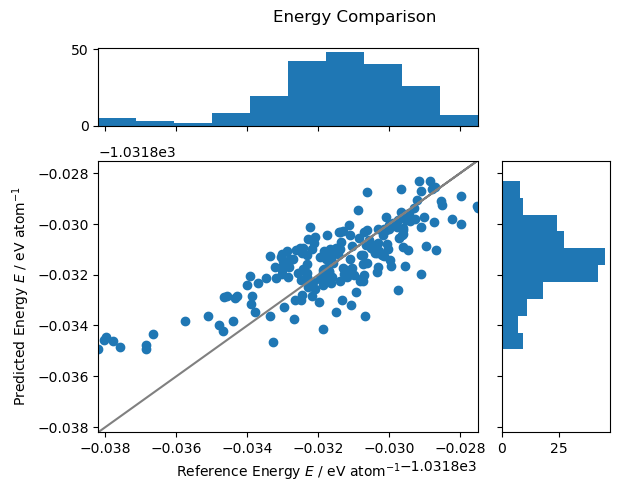

In [16]:
runnercalc.plot.energy_hdnnp_vs_reference()
plt.show()

We will use the potential you just trained to calculate the harmonic frequencies of the formic acid dimer: 

For reference, we will save the experimental frequencies obtained in an earlier study (see source below) and the harmonic frequencies obtained with the chose electronic structure method.

[F. Kollipost, R. Wugt Larsen, A. V. Domanskaya, M. Nörenberg, and M. A. Suhm
, "Communication: The highest frequency hydrogen bond vibration and an experimental value for the dissociation energy of formic acid dimer", J. Chem. Phys. 136, 151101 (2012)](https://doi.org/10.1063/1.4704827)

In [17]:
EXP_FREQUENCIES = np.array([69.2, 161, 168.47, 194, 242, 264, 677, 698, 911, 922, 1050, 1060, 1214, 1218,
                            1364, 1375, 1415, 1454, 1670, 1746, 2900, 2938.5, 2949, 3084])

CCSDT_FREQUENCIES = np.array([76.36, 170.96, 185.95, 211.28, 257.76, 278.07, 687.78, 715.81, 959.6, 986.46,
                              1085.04, 1102.03, 1256.78, 1260.06, 1405.06, 1413.1, 1455.96, 1483.92, 1717.13,
                              1781.57, 3100.56, 3104.59, 3203.36, 3305.25])

### Structure Optimization

As a first step, we need to find the optimal geometry. The potential, however, is in a much too early stage to support geometry optimization. Fortunately, we have already optimized the structure with an existing potential and you can simply load the structure from a file:

In [18]:
fad = read('data/fad_equilibrium.data', ':', format='runner')[0]

Now, we can attach our trained potential to the structure and calculate the forces.

In [19]:
fad.calc = Runner(restart='mode2/mode2', label='vib_calculation/vib', command=RUNNER_COMMAND)
fad.get_forces()

array([[ 0.0347099 ,  0.        , -0.2740282 ],
       [-0.0347099 ,  0.        ,  0.2740282 ],
       [ 0.10171285,  0.        , -0.03352719],
       [-0.10171285,  0.        ,  0.03352719],
       [ 0.12624117,  0.        ,  0.02267713],
       [-0.12624117,  0.        , -0.02267713],
       [-0.2533051 ,  0.        , -0.14562729],
       [ 0.25335652,  0.        ,  0.14562729],
       [-0.02581388,  0.        ,  0.36303979],
       [ 0.02581388,  0.        , -0.36303979]])

Finally, we can make use of ASE's `Vibration` module to calculate the numerical Hessian and, thus, the harmonic vibrational frequencies.

In [20]:
vib = Vibrations(fad, name='vib')
vib.run()
vib.summary()

---------------------
  #    meV     cm^-1
---------------------
  0   27.8i    224.3i
  1   17.9i    144.2i
  2   17.4i    140.3i
  3   14.1i    114.1i
  4    8.0i     64.8i
  5    0.5i      4.0i
  6    1.0       7.8
  7    1.2       9.6
  8    1.9      15.3
  9    3.8      30.4
 10    5.9      48.0
 11    8.6      69.4
 12   10.5      85.0
 13   11.3      91.3
 14   13.3     107.2
 15   15.0     120.9
 16   17.2     138.3
 17   22.4     180.8
 18   23.2     187.1
 19   37.2     300.1
 20   43.0     346.7
 21   50.3     406.0
 22   63.2     510.0
 23   63.3     510.2
 24   67.4     543.3
 25   71.3     575.0
 26   73.7     594.6
 27   78.1     629.7
 28   92.5     746.4
 29  105.7     852.2
---------------------
Zero-point energy: 0.440 eV


Let's compare the obtained frequencies, despite the first six ones which belong to the translational and rotational degrees of freedom, to the reference values:

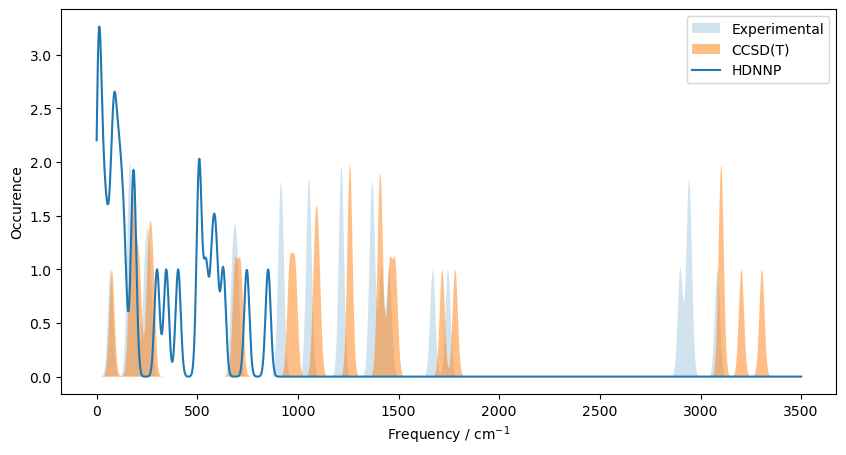

In [21]:
ase_frequencies = vib.get_frequencies()[6:].real.astype(int)

intensities = np.ones(len(ase_frequencies))
energies_hdnnp, spectrum_hdnnp = vib.fold(ase_frequencies, intensities, start=0.,
                                          end=3500., type='Gaussian', width=30.0)

energies_exp, spectrum_exp = vib.fold(EXP_FREQUENCIES, intensities, start=0.,
                                          end=3500., type='Gaussian', width=30.0)

energies_ccsdt, spectrum_ccsdt = vib.fold(CCSDT_FREQUENCIES, intensities, start=0.,
                                        end=3500., type='Gaussian', width=30.0)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Plot experimental data.
# ax.plot(energies_exp, spectrum_exp, alpha=0.5)
ax.fill_between(energies_exp, spectrum_exp, label='Experimental', alpha=0.2)

# Plot CCSDT data.
# ax.plot(energies_ccsdt, spectrum_ccsdt, alpha=0.5)
ax.fill_between(energies_ccsdt, spectrum_ccsdt, label='CCSD(T)', alpha=0.5)

# Plot HDNNP data.
ax.plot(energies_hdnnp, spectrum_hdnnp, alpha=1.0, label='HDNNP')
# ax.fill_between(energies_hdnnp, spectrum_hdnnp, label='HDNNP', alpha=0.2)

plt.xlabel('Frequency / cm$^{-1}$')
plt.ylabel('Occurence')
plt.legend(loc='upper right');
plt.show()

As expected, the very simple potential you trained, can not reproduce the experimental or (fc-)CCSD(T)-F12a results.

## Working with a Final Potential

The potential that you trained yourself is only based on a small selection of the full training dataset. We have pretrained a potential which you can simply load into ASE in a few lines of code: 

In [22]:
# Load the RuNNer parameters and files.
fad = read('data/fad_equilibrium.data', ':', format='runner')[0]
options = read_runnerconfig('data/pretrained_potential/input.nn')
scaling = RunnerScaling('data/pretrained_potential/scaling.data')
weights = RunnerWeights(path='data/pretrained_potential/')

# Create the calculator object.
runnercalc = Runner(scaling=scaling, weights=weights, **options, label='vib_calculation_pretrained/vib',
                    command=RUNNER_COMMAND)

In [23]:
view_ngl(fad)

NGLWidget()

ASE provides a separate module for calculating the numerical Hessian. As a first step, we calculate the forces of the structure `fad`.

In [24]:
fad.calc = runnercalc
runnercalc.reset()

fad.get_forces()

array([[ 0.00000000e+00,  0.00000000e+00, -2.57110335e-04],
       [ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00],
       [ 5.14220671e-05,  0.00000000e+00, -1.02844134e-04],
       [ 0.00000000e+00,  0.00000000e+00,  1.02844134e-04],
       [-2.57110335e-04,  0.00000000e+00, -2.05688268e-04],
       [-5.14220671e-04,  0.00000000e+00, -5.65642738e-04],
       [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.02844134e-04,  0.00000000e+00, -1.02844134e-04],
       [ 2.05688268e-04,  0.00000000e+00,  5.14220671e-04],
       [ 4.11376537e-04,  0.00000000e+00,  6.68486872e-04]])

In [25]:
vib = Vibrations(fad, name='vib_pretrained')
vib.run()
vib.summary()

---------------------
  #    meV     cm^-1
---------------------
  0    1.5i     12.1i
  1    1.0i      8.1i
  2    0.5       3.8
  3    1.0       7.7
  4    1.1       9.2
  5    1.3      10.7
  6    8.8      70.8
  7   20.7     166.6
  8   22.3     179.7
  9   26.5     214.1
 10   31.9     257.4
 11   34.1     274.9
 12   85.2     687.4
 13   88.2     711.6
 14  118.7     957.3
 15  121.4     979.0
 16  134.3    1083.1
 17  137.5    1108.7
 18  155.9    1257.1
 19  156.2    1259.7
 20  174.8    1409.7
 21  174.8    1410.1
 22  180.9    1459.1
 23  184.3    1486.1
 24  213.5    1721.7
 25  221.2    1784.1
 26  384.3    3099.8
 27  384.7    3102.8
 28  398.0    3209.8
 29  410.7    3312.4
---------------------
Zero-point energy: 1.936 eV


We can plot the frequencies in several different ways. Here, we are 'fold'ing together all frequencies in an interval of 40 wavenumbers to obtain a smooth plot. 

In [26]:
ase_frequencies = vib.get_frequencies()[6:].real.astype(int)

intensities = np.ones(len(ase_frequencies))
energies_hdnnp, spectrum_hdnnp = vib.fold(ase_frequencies, intensities, start=0.,
                                          end=3500., type='Gaussian', width=30.0)

energies_exp, spectrum_exp = vib.fold(EXP_FREQUENCIES, intensities, start=0.,
                                          end=3500., type='Gaussian', width=30.0)

energies_ccsdt, spectrum_ccsdt = vib.fold(CCSDT_FREQUENCIES, intensities, start=0.,
                                        end=3500., type='Gaussian', width=30.0)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Plot experimental data.
# ax.plot(energies_exp, spectrum_exp, alpha=0.5)
ax.fill_between(energies_exp, spectrum_exp, label='Experimental', alpha=0.2)

# Plot CCSDT data.
# ax.plot(energies_ccsdt, spectrum_ccsdt, alpha=0.5)
ax.fill_between(energies_ccsdt, spectrum_ccsdt, label='CCSD(F12*)(T)', alpha=0.5)

# Plot HDNNP data.
ax.plot(energies_hdnnp, spectrum_hdnnp, alpha=1.0, label='HDNNP')
# ax.fill_between(energies_hdnnp, spectrum_hdnnp, label='HDNNP', alpha=0.2)

plt.xlabel('Frequency / cm$^{-1}$')
plt.ylabel('Occurence')
plt.legend(loc='upper right');
plt.show()

We can also visualize the modes.

In [27]:
vibdata = vib.get_vibrations()
modes = vibdata.get_modes()

In [28]:
@widgets.interact(mode=(6, len(vibdata.get_modes()) - 1, 1))
def update(mode=6):
    # Get the trajectory data.
    atoms = list(vibdata.iter_animated_mode(mode, frames=60))
    freq = vibdata.get_frequencies()[mode].real

    print(f'Vib. Frequency: {freq:.1f} / cm')
    display(view_ngl(atoms))

interactive(children=(IntSlider(value=6, description='mode', max=29, min=6), Output()), _dom_classes=('widget-…

### Resources

Here is a collection of all the resources mentioned in the text. These are a very good starting points towards using RuNNer in your own research!

* Technical Documentation:
    * [The RuNNer documentation](https://theochemgoettingen.gitlab.io/RuNNer).
    * [The runnerase documentation](https://runner-suite.gitlab.io/runnerase/).
    * [The n2p2 documentation](https://compphysvienna.github.io/n2p2/index.html).
* Second Generation HDNNP:
    * [J. Behler, M. Parrinello, Phys. Rev. Lett. 2007, 98, 146401](https://www.doi.org/10.1103/PhysRevLett.98.146401).
    * [J. Behler, International Journal of Quantum Chemistry 2015, 115, 1032–1050](https://www.doi.org/10.1002/qua.24890).
    * [J. Behler, Angewandte Chemie International Edition 2017, 56, 12828–12840](https://www.doi.org/10.1002/anie.201703114).
* Third Generation HDNNP:
    * [N. Artrith, T. Morawietz, J. Behler, Phys. Rev. B 2011, 83, 153101](https://www.doi.org/10.1103/PhysRevB.83.153101).
    * [T. Morawietz, V. Sharma, J. Behler, J. Chem. Phys. 2012, 136, 064103](https://www.doi.org/10.1063/1.3682557).
* Fourth Generation HDNNP:
    * [T. W. Ko, J. A. Finkler, S. Goedecker, J. Behler, Nature Communications 2021, 12, 398](https://www.doi.org/10.1038/s41467-020-20427-2).
    * [T. W. Ko, J. A. Finkler, S. Goedecker, J. Behler, Acc. Chem. Res. 2021, 54, 808–817](https://www.doi.org/10.1021/acs.accounts.0c00689).
* Atom-centered Symmetry Functions:
    * [J. Behler, The Journal of Chemical Physics 2011, 134, 074106.](https://www.doi.org/10.1063/1.3553717).
* Further Reading / Tutorial Reviews:
    * [J. Behler, Journal of Physics: Condensed Matter 2014, 26, 183001](https://www.doi.org/10.1088/0953-8984/26/18/183001).
    * [J. Behler, Phys. Chem. Chem. Phys. 2011, 13, 17930–17955](https://www.doi.org/10.1039/C1CP21668F).
    * [J. Behler, International Journal of Quantum Chemistry 2015, 115, 1032–1050](https://www.doi.org/10.1002/qua.24890).